In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('custom_modules')

import Data_processing as dp

from IPython.display import display
from matplotlib import ticker
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Пути к X части выборки с массивами в каждой ячейке
path_to_array_like_X_data = ('data/Prepared data/Run1/X_data_array_like.xlsx',
                             'data/Prepared data/Run2/X_data_array_like.xlsx')
# Пути к Y части выборки
path_to_Y_data = ('data/Prepared data/Run1/Y_data(binary_classification).xlsx', 
                  'data/Prepared data/Run2/Y_data(binary_classification).xlsx') 


### Константы для обработки данных

In [3]:
PREP_image_size = 64
PREP_crop_step = 25

In [4]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

# Подготовка данных

In [5]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

for i,x_data_path,y_data_path in zip(range(len(path_to_array_like_X_data)),
                                     path_to_array_like_X_data, 
                                     path_to_Y_data):
    
    x_temp = dp.get_array_like_X_df(x_data_path)
    y_temp = dp.get_Y_df(y_data_path)
    
    
    
    X_dict[f'run{i+1}'] = {'train': {'df' : x_temp.iloc[:,:int(x_temp.shape[1]/2)]}, 
                           'test': {'df' : x_temp.iloc[:,int(x_temp.shape[1]/2):]}}
    Y_dict[f'run{i+1}'] = {'train': {'df' : y_temp.iloc[:,:int(y_temp.shape[1]/2)]}, 
                           'test': {'df' : y_temp.iloc[:,int(y_temp.shape[1]/2):]}}

In [6]:
print('Загружены данные для X выборки из файлов: ', X_dict.keys())
print('Загружены данные для Y выборки из файлов: ', Y_dict.keys())

Загружены данные для X выборки из файлов:  dict_keys(['run1', 'run2'])
Загружены данные для Y выборки из файлов:  dict_keys(['run1', 'run2'])


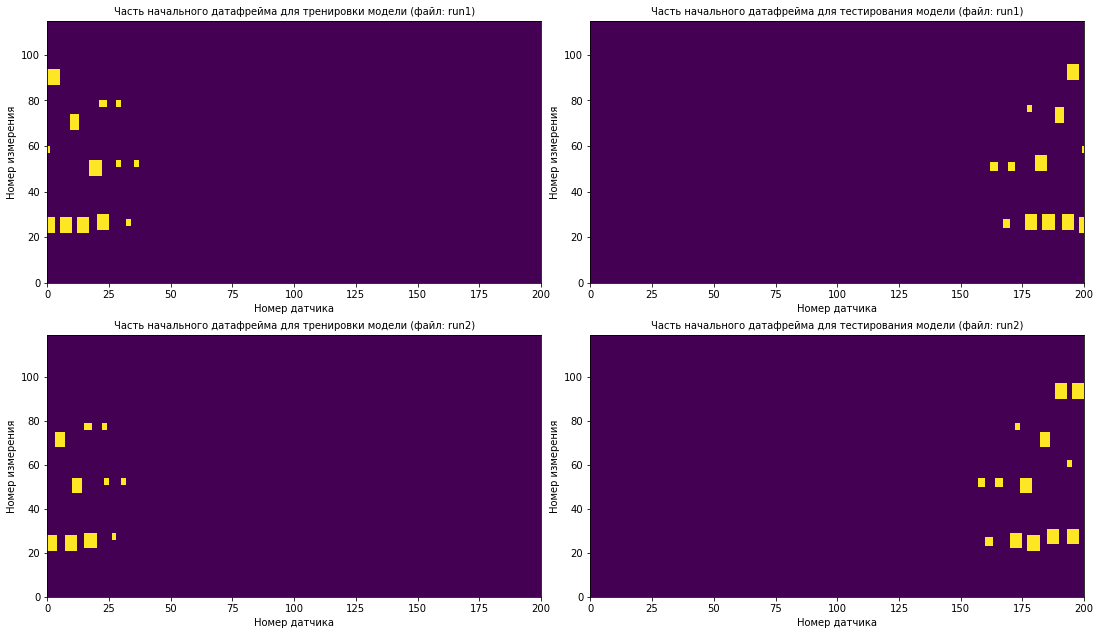

In [7]:
fig, axes = plt.subplots(2,2)

fig.set_figwidth(18)
fig.set_figheight(10)

for ax,key in zip(axes,Y_dict.keys()):
    ax[0].pcolormesh(Y_dict[key]['train']['df'])

    ax[0].set_xlabel('Номер датчика', fontsize=10) 
    ax[0].set_ylabel('Номер измерения', fontsize=10) 
    ax[0].set_title(f'Часть начального датафрейма для тренировки модели (файл: {key})', fontsize=10) 

    ax[1].pcolormesh(Y_dict[key]['test']['df'])

    ax[1].set_xlabel('Номер датчика', fontsize=10) 
    ax[1].set_ylabel('Номер измерения', fontsize=10) 
    ax[1].set_title(f'Часть начального датафрейма для тестирования модели (файл: {key})', fontsize=10) 

     
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

In [8]:
# добавление строк в датафреймы
for i,key in zip(range(len(X_dict.keys())),X_dict.keys()):
    print(f"||||||||||| step:  {i} |||||||||||")
    for qkey in X_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        print('||||||||||| X df preprocessing |||||||||||')
        X_dict[key][qkey]['df'] = dp.reshape_df_for_future_crops(X_dict[key][qkey]['df'], 
                                                                    PREP_image_size, 
                                                                    PREP_crop_step)
        print('||||||||||| Y df preprocessing |||||||||||')
        Y_dict[key][qkey]['df'] = dp.reshape_df_for_future_crops(Y_dict[key][qkey]['df'], 
                                                                    PREP_image_size, 
                                                                    PREP_crop_step) 


    print('\n')

||||||||||| step:  0 |||||||||||
|||||||||||||| dataset: train||||||||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 200)
Crop windows height/width:  64
Crop windows step across rows and cols:  25
New df shape:  (139, 214)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 200)
Crop windows height/width:  64
Crop windows step across rows and cols:  25
New df shape:  (139, 214)
||||||||||||||||||

|||||||||||||| dataset: test||||||||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (115, 200)
Crop windows height/width:  64
Crop windows step across rows and cols:  25
New df shape:  (139, 214)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Df reshaping for exact splittin

In [9]:
# запишем в словарь numpy array полученные из df
for i,key in zip(range(len(X_dict.keys())),X_dict.keys()):
    print(f"|||||||||||||| step: {i+1}||||||||||||||||")
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in X_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        print('||||||||||| X df preprocessing |||||||||||')
        x_time_temp, \
        x_amp_temp = dp.reshape_X_df_to_image_like_numpy(X_dict[key][qkey]['df'], 
                                                            PREP_image_size, 
                                                            PREP_crop_step)
        X_dict[key][qkey]['X_time_all'] = x_time_temp
        X_dict[key][qkey]['X_amp_all'] = x_amp_temp
        
        print('||||||||||| Y df preprocessing |||||||||||')
        y_temp = dp.reshape_Y_df_to_image_like_numpy(Y_dict[key][qkey]['df'], 
                                                     PREP_image_size, 
                                                     PREP_crop_step)
        Y_dict[key][qkey]['Y_mask_all'] = y_temp
        
    print('\n')
    
    

|||||||||||||| step: 1||||||||||||||||
|||||||||||||| file: run1||||||||||||||||
|||||||||||||| dataset: train||||||||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (139, 214)
Crop windows height/width:  64
New X_time shape:  (28, 64, 64, 32)
New X_amp shape:  (28, 64, 64, 32)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Y df reshaping to 3D
Original df size:  (139, 214)
Crop windows height/width:  64
New numpy shape:  (28, 64, 64, 1)
||||||||||||||||||

|||||||||||||| dataset: test||||||||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (139, 214)
Crop windows height/width:  64
New X_time shape:  (28, 64, 64, 32)
New X_amp shape:  (28, 64, 64, 32)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Y df reshaping to 3D
Original df size:  (139, 214)
Crop windows height/width:  64
New numpy shape:

In [10]:
print('||||||||||||||||||||||||||||')
print('Данные считаны для файлов: ',X_dict.keys())
print('\n||||||||||| X data |||||||||||')
for key in X_dict.keys():
    for qkey in X_dict[key].keys():
        print(f'Для файла \"{key}\" для \"{qkey}\" \"X\" выборки считано ', X_dict[key][qkey].keys())

print('\n||||||||||| Y data |||||||||||')        
for key in Y_dict.keys():
    for qkey in Y_dict[key].keys():
        print(f'Для файла \"{key}\" для \"{qkey}\" \"Y\" выборки считано ', Y_dict[key][qkey].keys())

||||||||||||||||||||||||||||
Данные считаны для файлов:  dict_keys(['run1', 'run2'])

||||||||||| X data |||||||||||
Для файла "run1" для "train" "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all'])
Для файла "run1" для "test" "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all'])
Для файла "run2" для "train" "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all'])
Для файла "run2" для "test" "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all'])

||||||||||| Y data |||||||||||
Для файла "run1" для "train" "Y" выборки считано  dict_keys(['df', 'Y_mask_all'])
Для файла "run1" для "test" "Y" выборки считано  dict_keys(['df', 'Y_mask_all'])
Для файла "run2" для "train" "Y" выборки считано  dict_keys(['df', 'Y_mask_all'])
Для файла "run2" для "test" "Y" выборки считано  dict_keys(['df', 'Y_mask_all'])


In [11]:
# обработка данных
for i,key in zip(range(len(X_dict.keys())),X_dict.keys()):
    print(f"|||||||||||||| step: {i+1}||||||||||||||||")
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in X_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        print('||||||||||| X df preprocessing |||||||||||')
        
        (X_time_def, X_time_non_def), \
        (X_amp_def, X_amp_non_def), \
        (Y_mask_def, Y_mask_non_def), \
        (Y_binary_def, Y_binary_non_def) = dp.preprocess_data(X_dict[key][qkey]['X_time_all'], 
                                                                        X_dict[key][qkey]['X_amp_all'], 
                                                                        Y_dict[key][qkey]['Y_mask_all'],
                                                                        PREP_image_size)

        X_dict[key][qkey]['X_time_def'] = X_time_def
        X_dict[key][qkey]['X_time_non_def'] = X_time_non_def

        X_dict[key][qkey]['X_amp_def'] = X_amp_def
        X_dict[key][qkey]['X_amp_non_def'] = X_amp_non_def

        Y_dict[key][qkey]['Y_mask_def'] = Y_mask_def
        Y_dict[key][qkey]['Y_mask_non_def'] = Y_mask_non_def
        
        Y_dict[key][qkey]['Y_binary_def'] = Y_binary_def
        Y_dict[key][qkey]['Y_binary_non_def'] = Y_binary_non_def

|||||||||||||| step: 1||||||||||||||||
|||||||||||||| file: run1||||||||||||||||
|||||||||||||| dataset: train||||||||||||||||
||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Data preprocessing
Orig X_time shape:  (28, 64, 64, 32)
Orig X_amp shape:  (28, 64, 64, 32)
Orig Y_mask shape:  (28, 64, 64, 1)
||||||||||||||||||
Data standartization
X_time_max: 44.4
X_amp_max: 62.738

X_time_max after standartization: 1.0
X_time_min after standartization: 0.0

X_amp_max after standartization: 1.0
X_amp_min after standartization: -0.9877267365870764
||||||||||||||||||

||||||||||||||||||
Data with and witout defects splitting
||||||||||||||||||
Defects nums calculating
Для карт высотой и шириной в 64
и общим кличеством: 28
дефекты присутствуеют на 8 картах
||||||||||||||||||

X_time_def shape:  (8, 64, 64, 32)
X_time_non_def shape:  (20, 64, 64, 32)

X_amp_def shape:  (8, 64, 64, 32)
X_amp_non_def shape:  (20, 64, 64, 32)

Y_mask_def shape:  (8, 64, 64, 1)
Y_mask_non_def shape:  (2

In [12]:
print('||||||||||||||||||||||||||||')
print('Данные считаны для файлов: ',X_dict.keys())
print('\n||||||||||| X data |||||||||||')
for key in X_dict.keys():
    for qkey in X_dict[key].keys():
        print(f'Для файла \"{key}\" для \"{qkey}\" \"X\" выборки считано ', X_dict[key][qkey].keys())

print('\n||||||||||| Y data |||||||||||')        
for key in Y_dict.keys():
    for qkey in Y_dict[key].keys():
        print(f'Для файла \"{key}\" для \"{qkey}\" \"Y\" выборки считано ', Y_dict[key][qkey].keys())

||||||||||||||||||||||||||||
Данные считаны для файлов:  dict_keys(['run1', 'run2'])

||||||||||| X data |||||||||||
Для файла "run1" для "train" "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])
Для файла "run1" для "test" "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])
Для файла "run2" для "train" "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])
Для файла "run2" для "test" "X" выборки считано  dict_keys(['df', 'X_time_all', 'X_amp_all', 'X_time_def', 'X_time_non_def', 'X_amp_def', 'X_amp_non_def'])

||||||||||| Y data |||||||||||
Для файла "run1" для "train" "Y" выборки считано  dict_keys(['df', 'Y_mask_all', 'Y_mask_def', 'Y_mask_non_def', 'Y_binary_def', 'Y_binary_non_def'])
Для файла "run1" для "test" "Y" выборки считано  dict_keys(['df', 'Y_mask_a

In [13]:
print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in X_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        for wkey in X_dict[key][qkey].keys():
            print(f"{wkey}.shape: ", X_dict[key][qkey][wkey].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in Y_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        for wkey in Y_dict[key][qkey].keys():
            print(f"{wkey}.shape: ", Y_dict[key][qkey][wkey].shape)

|||||||||||||| X dataset ||||||||||||||||
|||||||||||||| file: run1||||||||||||||||
|||||||||||||| dataset: train||||||||||||||||
df.shape:  (139, 214)
X_time_all.shape:  (28, 64, 64, 32)
X_amp_all.shape:  (28, 64, 64, 32)
X_time_def.shape:  (8, 64, 64, 32)
X_time_non_def.shape:  (20, 64, 64, 32)
X_amp_def.shape:  (8, 64, 64, 32)
X_amp_non_def.shape:  (20, 64, 64, 32)
|||||||||||||| dataset: test||||||||||||||||
df.shape:  (139, 214)
X_time_all.shape:  (28, 64, 64, 32)
X_amp_all.shape:  (28, 64, 64, 32)
X_time_def.shape:  (11, 64, 64, 32)
X_time_non_def.shape:  (17, 64, 64, 32)
X_amp_def.shape:  (11, 64, 64, 32)
X_amp_non_def.shape:  (17, 64, 64, 32)
|||||||||||||| file: run2||||||||||||||||
|||||||||||||| dataset: train||||||||||||||||
df.shape:  (139, 214)
X_time_all.shape:  (28, 64, 64, 32)
X_amp_all.shape:  (28, 64, 64, 32)
X_time_def.shape:  (7, 64, 64, 32)
X_time_non_def.shape:  (21, 64, 64, 32)
X_amp_def.shape:  (7, 64, 64, 32)
X_amp_non_def.shape:  (21, 64, 64, 32)
||||||||||||

In [14]:
print('|||||||||||||||||| X data ||||||||||||||||||')
print('|||||||||||||||||| augment train data ||||||||||||||||||')
for key in X_dict.keys():
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in X_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        for wkey in X_dict[key][qkey].keys():
            print(f"|||||||||||||| dataset part: {wkey}||||||||||||||||")
            if wkey != "df" and wkey != "X_time_all" and wkey != "X_amp_all":
                X_dict[key][qkey][wkey] = dp.augment_data(X_dict[key][qkey][wkey])

print('\n|||||||||||||||||| Y data ||||||||||||||||||')
for key in Y_dict.keys():
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in Y_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        for wkey in Y_dict[key][qkey].keys():
            print(f"|||||||||||||| dataset part: {wkey}||||||||||||||||")
            if wkey != "df" and wkey != "Y_binary_def" and wkey != "Y_binary_non_def" and wkey != "Y_mask_all":
                Y_dict[key][qkey][wkey] = dp.augment_data(Y_dict[key][qkey][wkey])
                
                
for key in Y_dict.keys():
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in Y_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        for wkey in Y_dict[key][qkey].keys():
            print(f"|||||||||||||| dataset part: {wkey}||||||||||||||||")
            if wkey == "Y_binary_def":
                Y_dict[key][qkey][wkey] = np.ones(Y_dict[key][qkey]['Y_mask_def'].shape[0])
            if wkey == "Y_binary_non_def":
                Y_dict[key][qkey][wkey] = np.zeros(Y_dict[key][qkey]['Y_mask_non_def'].shape[0])

|||||||||||||||||| X data ||||||||||||||||||
|||||||||||||||||| augment train data ||||||||||||||||||
|||||||||||||| file: run1||||||||||||||||
|||||||||||||| dataset: train||||||||||||||||
|||||||||||||| dataset part: df||||||||||||||||
|||||||||||||| dataset part: X_time_all||||||||||||||||
|||||||||||||| dataset part: X_amp_all||||||||||||||||
|||||||||||||| dataset part: X_time_def||||||||||||||||
||||||||||||||||||
Data augmentation
Orig arr shape:  (8, 64, 64, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (32, 64, 64, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (64, 64, 64, 32)
||||||||||||
After vertical full mirroring
arr shape:  (128, 64, 64, 32)
||||||||||||
After vertical half shifting
arr shape:  (256, 64, 64, 32)
||||||||||||
After horizontal half shifting
X_time_arr shape:  (512, 64, 64, 32)
||||||||||||||||||

|||||||||||||| dataset part: X_time_non_def||||||||||||||||
||||||||||||||||||
Data augmentation
Orig arr shape:  (20, 64, 64, 32

||||||||||||
After horizontal half shifting
X_time_arr shape:  (1088, 64, 64, 32)
||||||||||||||||||

|||||||||||||| dataset part: X_amp_def||||||||||||||||
||||||||||||||||||
Data augmentation
Orig arr shape:  (11, 64, 64, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (44, 64, 64, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (88, 64, 64, 32)
||||||||||||
After vertical full mirroring
arr shape:  (176, 64, 64, 32)
||||||||||||
After vertical half shifting
arr shape:  (352, 64, 64, 32)
||||||||||||
After horizontal half shifting
X_time_arr shape:  (704, 64, 64, 32)
||||||||||||||||||

|||||||||||||| dataset part: X_amp_non_def||||||||||||||||
||||||||||||||||||
Data augmentation
Orig arr shape:  (17, 64, 64, 32)
||||||||||||
After 4 steps of 90 degree rotate
arr shape:  (68, 64, 64, 32)
||||||||||||
After horizontal full mirroring
arr shape:  (136, 64, 64, 32)
||||||||||||
After vertical full mirroring
arr shape:  (272, 64, 64, 32)
||||||||||||
After ver

In [15]:
print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in X_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        for wkey in X_dict[key][qkey].keys():
            print(f"{wkey}.shape: ", X_dict[key][qkey][wkey].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"|||||||||||||| file: {key}||||||||||||||||")
    for qkey in Y_dict[key].keys():
        print(f"|||||||||||||| dataset: {qkey}||||||||||||||||")
        for wkey in Y_dict[key][qkey].keys():
            print(f"{wkey}.shape: ", Y_dict[key][qkey][wkey].shape)

|||||||||||||| X dataset ||||||||||||||||
|||||||||||||| file: run1||||||||||||||||
|||||||||||||| dataset: train||||||||||||||||
df.shape:  (139, 214)
X_time_all.shape:  (28, 64, 64, 32)
X_amp_all.shape:  (28, 64, 64, 32)
X_time_def.shape:  (512, 64, 64, 32)
X_time_non_def.shape:  (1280, 64, 64, 32)
X_amp_def.shape:  (512, 64, 64, 32)
X_amp_non_def.shape:  (1280, 64, 64, 32)
|||||||||||||| dataset: test||||||||||||||||
df.shape:  (139, 214)
X_time_all.shape:  (28, 64, 64, 32)
X_amp_all.shape:  (28, 64, 64, 32)
X_time_def.shape:  (704, 64, 64, 32)
X_time_non_def.shape:  (1088, 64, 64, 32)
X_amp_def.shape:  (704, 64, 64, 32)
X_amp_non_def.shape:  (1088, 64, 64, 32)
|||||||||||||| file: run2||||||||||||||||
|||||||||||||| dataset: train||||||||||||||||
df.shape:  (139, 214)
X_time_all.shape:  (28, 64, 64, 32)
X_amp_all.shape:  (28, 64, 64, 32)
X_time_def.shape:  (448, 64, 64, 32)
X_time_non_def.shape:  (1344, 64, 64, 32)
X_amp_def.shape:  (448, 64, 64, 32)
X_amp_non_def.shape:  (1344, 64

In [16]:
val_data_percent = 0.2

X_time_train, X_time_val = dp.split_data_to_train_test_val_datasets([X_dict['run1']['train']['X_time_def'],
                                                                    X_dict['run1']['train']['X_time_non_def'],
                                                                    X_dict['run2']['train']['X_time_def'],
                                                                    X_dict['run2']['train']['X_time_non_def']],
                                                                        val_data_percent)
X_amp_train, X_amp_val = dp.split_data_to_train_test_val_datasets([X_dict['run1']['train']['X_amp_def'],
                                                                    X_dict['run1']['train']['X_amp_non_def'],
                                                                    X_dict['run2']['train']['X_amp_def'],
                                                                    X_dict['run2']['train']['X_amp_non_def']],
                                                                        val_data_percent)
Y_mask_train, Y_mask_val = dp.split_data_to_train_test_val_datasets([Y_dict['run1']['train']['Y_mask_def'],
                                                                    Y_dict['run1']['train']['Y_mask_non_def'],
                                                                    Y_dict['run2']['train']['Y_mask_def'],
                                                                    Y_dict['run2']['train']['Y_mask_non_def']],
                                                                        val_data_percent)
Y_binary_train, Y_binary_val = dp.split_data_to_train_test_val_datasets([Y_dict['run1']['train']['Y_binary_def'],
                                                                    Y_dict['run1']['train']['Y_binary_non_def'],
                                                                    Y_dict['run2']['train']['Y_binary_def'],
                                                                    Y_dict['run2']['train']['Y_binary_non_def']],
                                                                        val_data_percent)

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (512, 64, 64, 32)
Orig item shape:  (1280, 64, 64, 32)
Orig item shape:  (448, 64, 64, 32)
Orig item shape:  (1344, 64, 64, 32)

Result arr_train shape:  (2869, 64, 64, 32)
Result arr_val shape:  (715, 64, 64, 32)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (512, 64, 64, 32)
Orig item shape:  (1280, 64, 64, 32)
Orig item shape:  (448, 64, 64, 32)
Orig item shape:  (1344, 64, 64, 32)

Result arr_train shape:  (2869, 64, 64, 32)
Result arr_val shape:  (715, 64, 64, 32)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and train datasets
Orig item shape:  (512, 64, 64, 1)
Orig item shape:  (1280, 64, 64, 1)
Orig item shape:  (448, 64, 64, 1)
Orig item shape:  (1344, 64, 64, 1)

Result arr_train shape:  (2869, 64, 64, 1)
Result arr_val shape:  (715, 64, 64, 1)

||||||||||||||||||

||||||||||||||||||
Data spliting to test, val and tr

In [17]:
X_time_test = np.concatenate([X_dict['run1']['test']['X_time_def'],
                            X_dict['run1']['test']['X_time_non_def'],
                            X_dict['run2']['test']['X_time_def'],
                            X_dict['run2']['test']['X_time_non_def']],axis=0)
X_amp_test = np.concatenate([X_dict['run1']['test']['X_amp_def'],
                            X_dict['run1']['test']['X_amp_non_def'],
                            X_dict['run2']['test']['X_amp_def'],
                            X_dict['run2']['test']['X_amp_non_def']],axis=0)
Y_mask_test = np.concatenate([Y_dict['run1']['test']['Y_mask_def'],
                            Y_dict['run1']['test']['Y_mask_non_def'],
                            Y_dict['run2']['test']['Y_mask_def'],
                            Y_dict['run2']['test']['Y_mask_non_def']],axis=0)
Y_binary_test = np.concatenate([Y_dict['run1']['test']['Y_binary_def'],
                            Y_dict['run1']['test']['Y_binary_non_def'],
                            Y_dict['run2']['test']['Y_binary_def'],
                            Y_dict['run2']['test']['Y_binary_non_def']],axis=0)

In [18]:
train_shuffled_indices = np.random.permutation(X_time_train.shape[0])
val_shuffled_indices = np.random.permutation(X_time_val.shape[0])
test_shuffled_indices = np.random.permutation(X_time_test.shape[0])

X_time_train = X_time_train[train_shuffled_indices]
X_amp_train = X_amp_train[train_shuffled_indices]
Y_mask_train = Y_mask_train[train_shuffled_indices]
Y_binary_train = Y_binary_train[train_shuffled_indices]

X_time_val = X_time_val[val_shuffled_indices]
X_amp_val = X_amp_val[val_shuffled_indices]
Y_mask_val = Y_mask_val[val_shuffled_indices]
Y_binary_val = Y_binary_val[val_shuffled_indices]

X_time_test = X_time_test[test_shuffled_indices]
X_amp_test = X_amp_test[test_shuffled_indices]
Y_mask_test = Y_mask_test[test_shuffled_indices]
Y_binary_test = Y_binary_test[test_shuffled_indices]


In [19]:
print('X_time_train.shape: ', X_time_train.shape)
print('X_amp_train.shape: ', X_amp_train.shape)
print('Y_mask_train.shape', Y_mask_train.shape)
print('Y_binary_train.shape', Y_binary_train.shape)
print('\n')

print('X_time_val.shape: ', X_time_val.shape)
print('X_amp_val.shape: ', X_amp_val.shape)
print('Y_mask_val.shape', Y_mask_val.shape)
print('Y_binary_val.shape', Y_binary_val.shape)
print('\n')

print('X_time_test.shape: ', X_time_test.shape)
print('X_amp_test.shape: ', X_amp_test.shape)
print('Y_mask_test.shape', Y_mask_test.shape)
print('Y_binary_test.shape', Y_binary_test.shape)
print('\n')

X_time_train.shape:  (2869, 64, 64, 32)
X_amp_train.shape:  (2869, 64, 64, 32)
Y_mask_train.shape (2869, 64, 64, 1)
Y_binary_train.shape (2869,)


X_time_val.shape:  (715, 64, 64, 32)
X_amp_val.shape:  (715, 64, 64, 32)
Y_mask_val.shape (715, 64, 64, 1)
Y_binary_val.shape (715,)


X_time_test.shape:  (3584, 64, 64, 32)
X_amp_test.shape:  (3584, 64, 64, 32)
Y_mask_test.shape (3584, 64, 64, 1)
Y_binary_test.shape (3584,)




# CNN с 1 входом по времени

In [2]:
# всякие константы для последующей работы

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.000001 #0.04 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
#CMP_solver = keras.optimizers.SGD(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'mean_squared_error'# функция потерь
#///////////////////////////////// для колбэков

    # для Early_stopping
#ES_patience = 15 # кол-во эпох без улучшений
#ES_min_delta = 0.0005 # минимальное улучшение параметра за cur_patience
#ES_monitor_parametr =  'loss' # отслеживаемый параметр 
#ES_save_best_weights = False # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
#RLPOP_monitor_parametr = 'loss'  # отслеживаемый параметр 
#RLPOP_factor = 0.4 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
#RLPOP_patience = 10 # кол-во эпох без улучшений
#RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
#RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
#RLPOP_min_delta = 0.001 # порог изменения отслеживаемого значения
#RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
#RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 8 # размер bach при обучении/тестировании1
FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 3 # количество эпох обучения
#FIT_validation_split = 0.10 #0.20 # процент валидационных данных, отсекаемых из тестовой выборки

In [3]:
# 1 подсеть //////////////////////////////////////////////////

input_time = Input((64,64,32))

dconv_1_1 = Conv2D(32, (5,5), dilation_rate=(1, 1), activation='linear')(input_time)
up_1_1 = UpSampling2D(2, interpolation='bilinear') (dconv_1_1)

dconv_1_2 = Conv2D(32, (5,5), dilation_rate=(6, 6), activation='linear')(input_time)
up_1_2 = UpSampling2D(3, interpolation='bilinear') (dconv_1_2)

dconv_1_3 = Conv2D(32, (5,5), dilation_rate=(10, 10), activation='linear')(input_time)
up_1_3 = UpSampling2D(5, interpolation='bilinear') (dconv_1_3)

dconv_1_4 = Conv2D(32, (5,5), dilation_rate=(13, 13), activation='linear')(input_time)
up_1_4 = UpSampling2D(10, interpolation='bilinear') (dconv_1_4)

dconv_1_5 = Conv2D(32, (5,5), dilation_rate=(14, 14), activation='linear')(input_time)
up_1_5 = UpSampling2D(15, interpolation='bilinear') (dconv_1_5)

conc_1 = concatenate([up_1_1,up_1_2,up_1_3,up_1_4,up_1_5],axis=3)

conv_1_1 = Conv2D(64, (3,3), activation='linear')(conc_1)
conv_1_2 = Conv2D(64, (3,3), activation='linear')(conv_1_1)
conv_1_3 = Conv2D(64, (3,3), activation='linear')(conv_1_2)
conv_1_4 = Conv2D(64, (3,3), activation='linear')(conv_1_3)
pool_1_1 = MaxPooling2D((2,2), strides=2)(conv_1_4)
conv_1_5 = Conv2D(128, (3,3), activation='linear')(pool_1_1)
conv_1_6 = Conv2D(128, (3,3), activation='linear')(conv_1_5)
pool_1_2 = MaxPooling2D((2,2), strides=2)(conv_1_6)
conv_1_7 = Conv2D(256, (3,3), activation='linear')(pool_1_2)
conv_1_8 = Conv2D(256, (3,3), activation='linear')(conv_1_7)
conv_1_9 = Conv2D(256, (3,3), activation='linear')(conv_1_8)
pool_1_3 = MaxPooling2D((2,2), strides=2)(conv_1_9)
conv_1_10 = Conv2D(512, (3,3), activation='linear')(pool_1_3)
conv_1_11 = Conv2D(512, (3,3), activation='linear')(conv_1_10)
conv_1_12 = Conv2D(512, (3,3), activation='linear')(conv_1_11)
pool_1_4 = MaxPooling2D((2,2), strides=2)(conv_1_12)
conv_1_13 = Conv2D(1024, (2,2), activation='linear')(pool_1_4)

# 2 подсеть //////////////////////////////////////////////////

input_amp = Input((64,64,32))

dconv_2_1 = Conv2D(32, (5,5), dilation_rate=(1, 1), activation='linear')(input_amp)
up_2_1 = UpSampling2D(2, interpolation='bilinear') (dconv_2_1)

dconv_2_2 = Conv2D(32, (5,5), dilation_rate=(6, 6), activation='linear')(input_amp)
up_2_2 = UpSampling2D(3, interpolation='bilinear') (dconv_2_2)

dconv_2_3 = Conv2D(32, (5,5), dilation_rate=(10, 10), activation='linear')(input_amp)
up_2_3 = UpSampling2D(5, interpolation='bilinear') (dconv_2_3)

dconv_2_4 = Conv2D(32, (5,5), dilation_rate=(13, 13), activation='linear')(input_amp)
up_2_4 = UpSampling2D(10, interpolation='bilinear') (dconv_2_4)

dconv_2_5 = Conv2D(32, (5,5), dilation_rate=(14, 14), activation='linear')(input_amp)
up_2_5 = UpSampling2D(15, interpolation='bilinear') (dconv_2_5)

conc_2 = concatenate([up_2_1,up_2_2,up_2_3,up_2_4,up_2_5],axis=3)

conv_2_1 = Conv2D(64, (3,3), activation='linear')(conc_2)
conv_2_2 = Conv2D(64, (3,3), activation='linear')(conv_2_1)
conv_2_3 = Conv2D(64, (3,3), activation='linear')(conv_2_2)
conv_2_4 = Conv2D(64, (3,3), activation='linear')(conv_2_3)
pool_2_1 = MaxPooling2D((2,2), strides=2)(conv_2_4)
conv_2_5 = Conv2D(128, (3,3), activation='linear')(pool_2_1)
conv_2_6 = Conv2D(128, (3,3), activation='linear')(conv_2_5)
pool_2_2 = MaxPooling2D((2,2), strides=2)(conv_2_6)
conv_2_7 = Conv2D(256, (3,3), activation='linear')(pool_2_2)
conv_2_8 = Conv2D(256, (3,3), activation='linear')(conv_2_7)
conv_2_9 = Conv2D(256, (3,3), activation='linear')(conv_2_8)
pool_2_3 = MaxPooling2D((2,2), strides=2)(conv_2_9)
conv_2_10 = Conv2D(512, (3,3), activation='linear')(pool_2_3)
conv_2_11 = Conv2D(512, (3,3), activation='linear')(conv_2_10)
conv_2_12 = Conv2D(512, (3,3), activation='linear')(conv_2_11)
pool_2_4 = MaxPooling2D((2,2), strides=2)(conv_2_12)
conv_2_13 = Conv2D(1024, (2,2), activation='linear')(pool_2_4)

# выходная сеть //////////////////////////////////////////////////

conc = concatenate([conv_1_13,conv_2_13],axis=3)
flat = Flatten()(conc)

d_1 = Dense(2048, activation='linear')(flat)
d_2 = Dense(1024, activation='linear')(d_1)
d_3 = Dense(512, activation='linear')(d_2)
d_4 = Dense(256, activation='linear')(d_3)
d_5 = Dense(128, activation='linear')(d_4)
d_6 = Dense(64, activation='linear')(d_5)
d_7 = Dense(32, activation='linear')(d_6)
d_8 = Dense(16, activation='linear')(d_7)
d_9 = Dense(8, activation='linear')(d_8)
d_10 = Dense(4, activation='linear')(d_9)
d_11 = Dense(2, activation='linear')(d_10)
output = Dense(1, activation='sigmoid')(d_11)


model = keras.Model([input_time,input_amp], 
                    output, name='model')
model.compile(optimizer=CMP_solver, 
              loss=CMP_loss_func)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 32)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 60, 60, 32)   25632       ['input_1[0][0]']                
                                                                                              

 conv2d_7 (Conv2D)              (None, 114, 114, 64  36928       ['conv2d_6[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 114, 114, 64  36928       ['conv2d_24[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_8 (Conv2D)              (None, 112, 112, 64  36928       ['conv2d_7[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 112, 112, 64  36928       ['conv2d_25[0][0]']              
          

 dense_7 (Dense)                (None, 16)           528         ['dense_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 8)            136         ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 4)            36          ['dense_8[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 2)            10          ['dense_9[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 1)            3           ['dense_10[0][0]']               
                                                                                                  
Total para

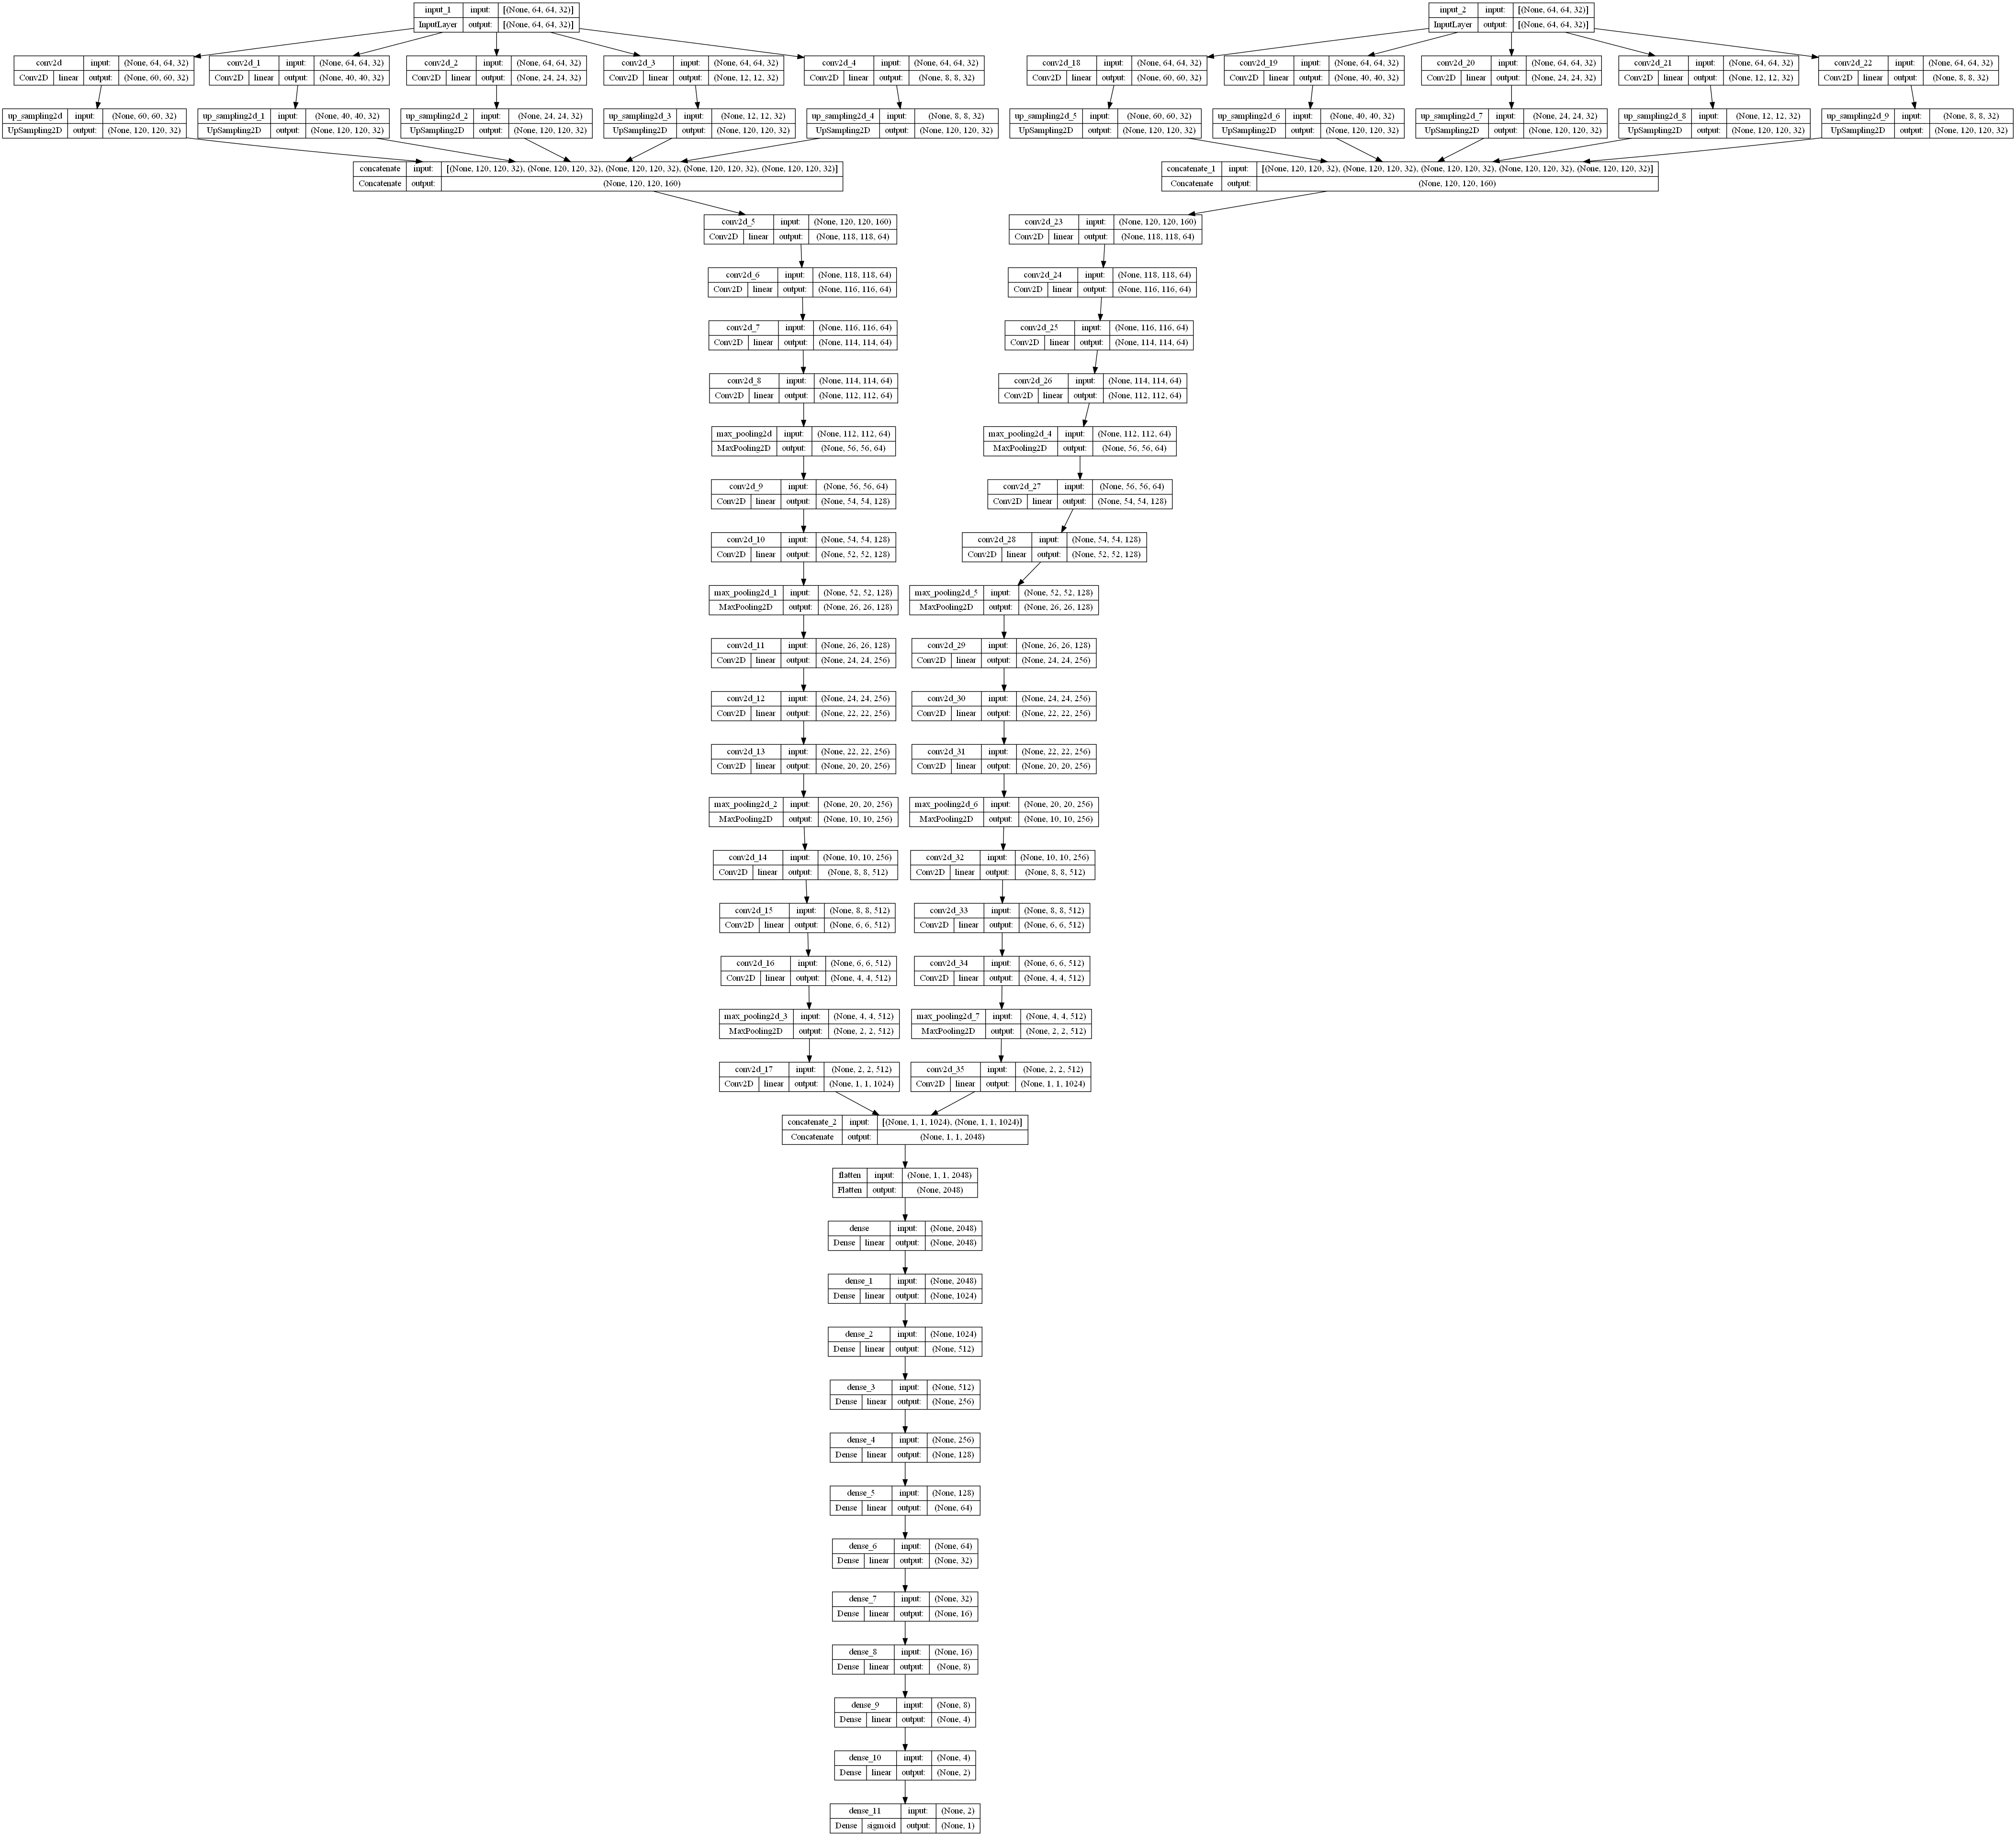

In [4]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [33]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

'''temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)'''

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [34]:
history = model.fit([X_time_train,X_amp_train],
                    Y_binary_train,
                    batch_size = FIT_batch_size, 
                    epochs = FIT_epochs, 
                    verbose = FIT_verbose, 
                    validation_data = ([X_time_val,X_amp_val],Y_binary_val), 
                    shuffle = FIT_shuffle,
                    callbacks = FIT_callback_list)

359/359 [==============================] - 537s 1s/step - loss: 0.0317 - val_loss: 0.0384


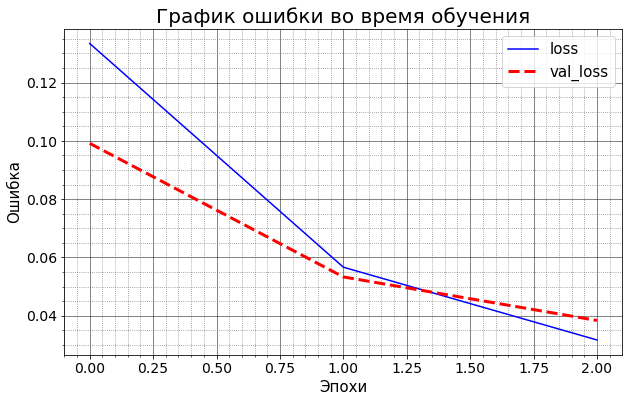

In [35]:
# Вывод графика изменения ошибки

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

plt.plot(history.history['loss'], label='loss',  linewidth=1.5, color='blue')
plt.plot(history.history['val_loss'], linestyle = '--', label='val_loss',  linewidth=3, color='red')

ax.set_title('График ошибки во время обучения', fontsize=20)
ax.set_ylabel('Ошибка', fontsize=15)
ax.set_xlabel('Эпохи', fontsize=15)

#  Устанавливаем форматирование делений:
ax.xaxis.set_tick_params(which = 'major', labelsize = 14)
ax.yaxis.set_tick_params(which = 'major', labelsize = 14)

ax.minorticks_on()
ax.grid(which='major', color = 'k', alpha = 0.6)
ax.grid(which='minor', color = 'gray', linestyle = ':')

ax.legend(fontsize = 15, facecolor = "white", loc = 'upper right')

plt.show()

In [36]:
# тест модели
model.evaluate([X_time_test,X_amp_test], Y_binary_test, batch_size = FIT_batch_size)

448/448 [==============================] - 166s 370ms/step - loss: 0.3010


0.30098479986190796

In [37]:
model.save("Networks//CNN//NetWork_(64x32+64x32)_to(1)_0dot3010.h5", save_format="h5")